Sample guide:
985
Empty
986
H2B WT-flag
987
H2B E76K-flag
988
H2B E76R-flag
989
H2B G53D-flag
990
H2B G53E-flag
991
H2B G53K-flag
992
H2B G53R-flag

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adata = sc.read_h5ad('write/Hir_986.h5ad')

In [48]:
#subsetting anndata objs
#data4 = data4[:100, :]
#variable index (second part of index above) is used to extract information on variables
data4.var.index[data4.var.index=='FMN2']
data4.var.index[0]

NameError: name 'data4' is not defined

In [ ]:
# Export the AnnData object to a CSV file
#data4.write_csvs("data4.csv")

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.2 scikit-learn==1.2.0 statsmodels==0.13.5 python-igraph==0.10.3 pynndescent==0.5.8


You MUST change the results_file and input .mtx file for each run

In [ ]:
#CHANGE THIS
results_file = 'write/Hir_992.h5ad'  # the file that will store the analysis results

In [34]:
#CHANGE THIS
adata = sc.read_10x_mtx(
    r'C:\Users\zchua\Documents\Hir_scRNAseq_output\986_output\filtered_feature_bc_matrix', # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache\C-Users-zchua-Documents-Hir_scRNAseq_output-986_output-filtered_feature_bc_matrix-matrix.h5ad


In [ ]:
#DISREGARD
for i in range(985,993,1):
    print("reading in " "C:\\Users\\zchua\\Documents\\Hir_scRNAseq_output\\"+str(i)+"_output\\filtered_feature_bc_matrix")
    # I can make it loop but will likely just make things too complicated downstream

normalizing counts per cell
    finished (0:00:00)


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


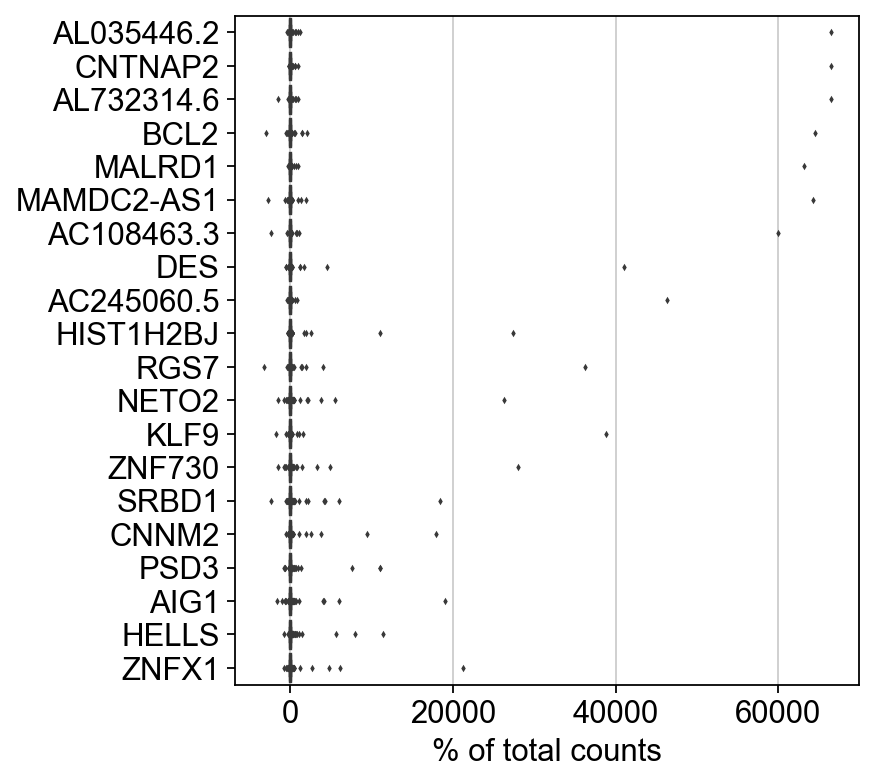

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20)

Filtering
- Remove cells with < 300 genes
- Remove genes in < 3 cells
- Remove cells with > 6% reads mapping to mt genes

In [35]:
sc.pp.filter_cells(adata, min_genes=300) #filters out cells with less than 300 genes
sc.pp.filter_genes(adata, min_cells=3) #filter out genes in less than 3 cells
adata

filtered out 24 cells that have less than 300 genes expressed
filtered out 9463 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 16471 × 27138
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [36]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

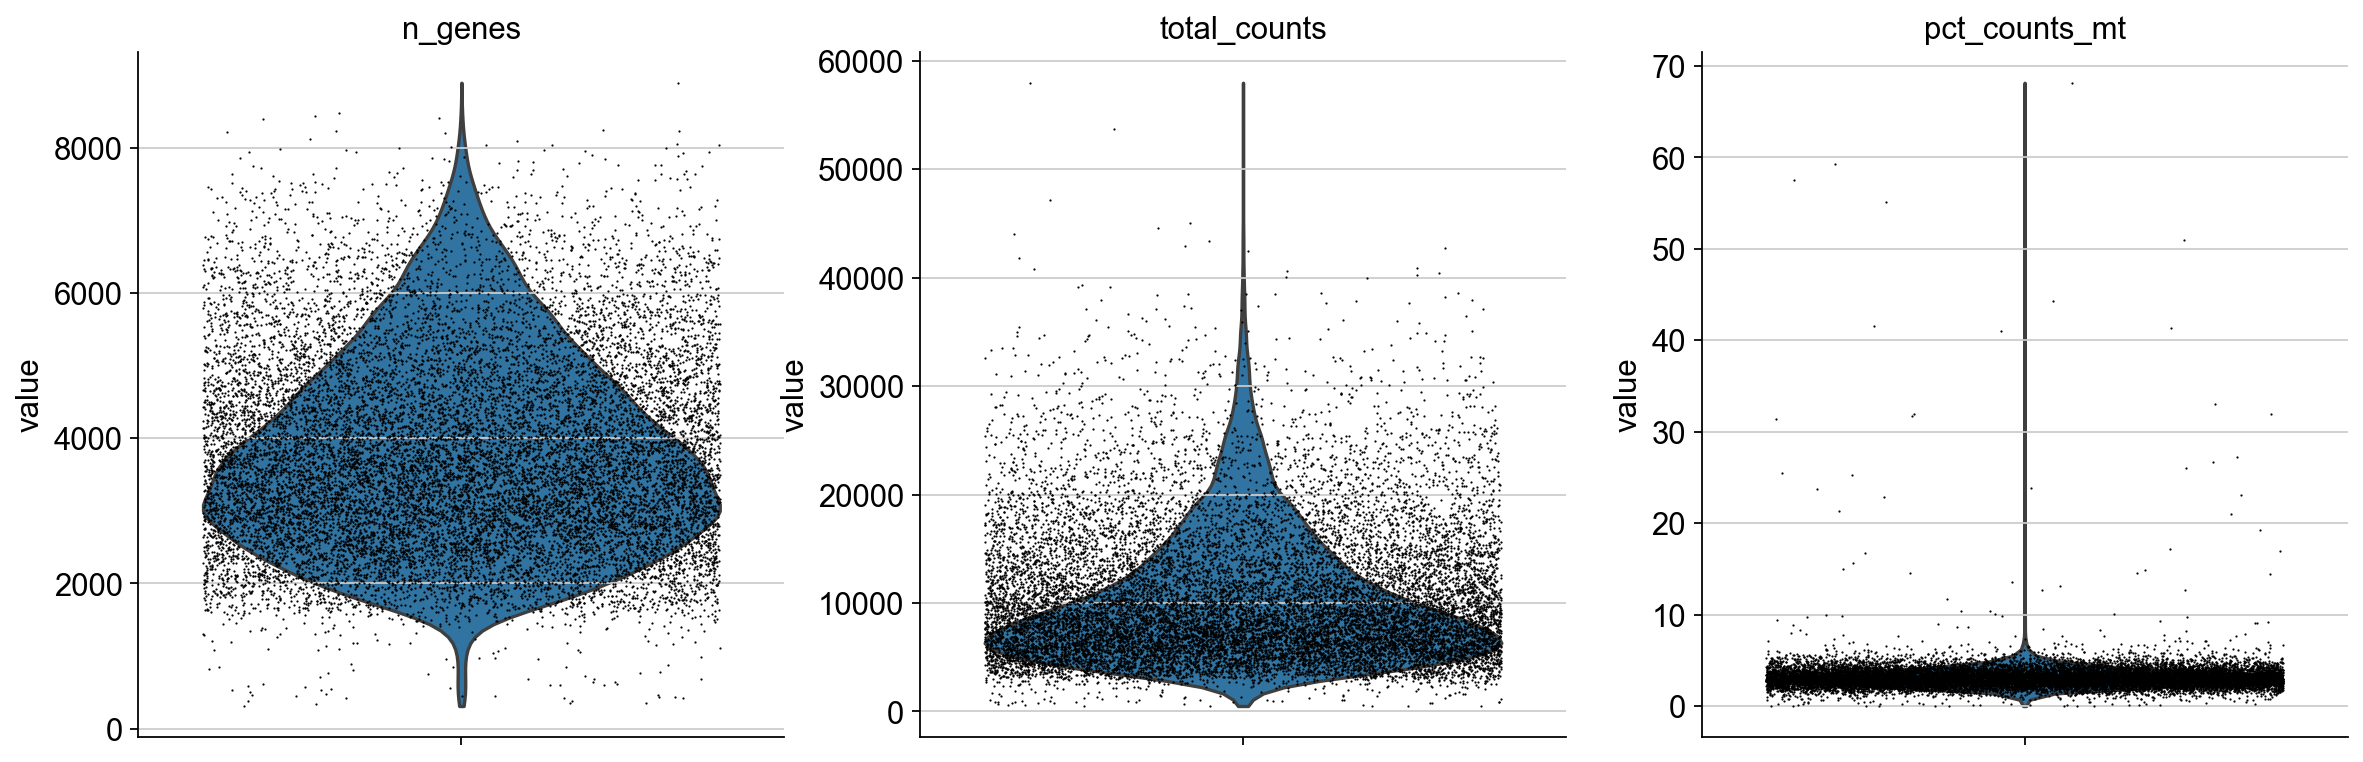

In [6]:
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

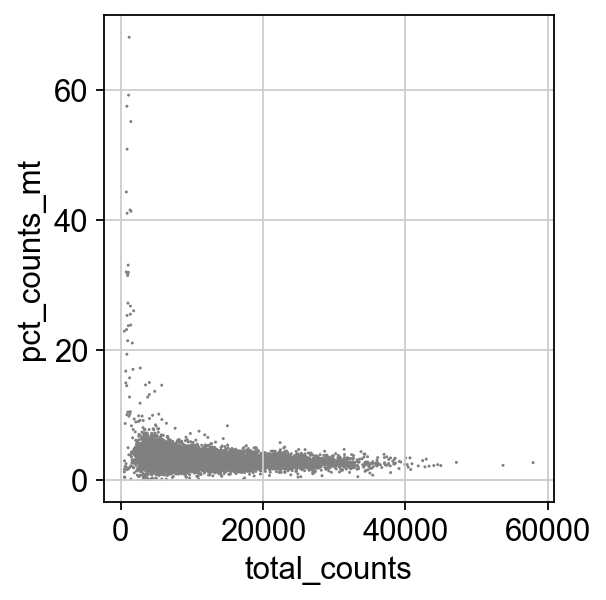

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

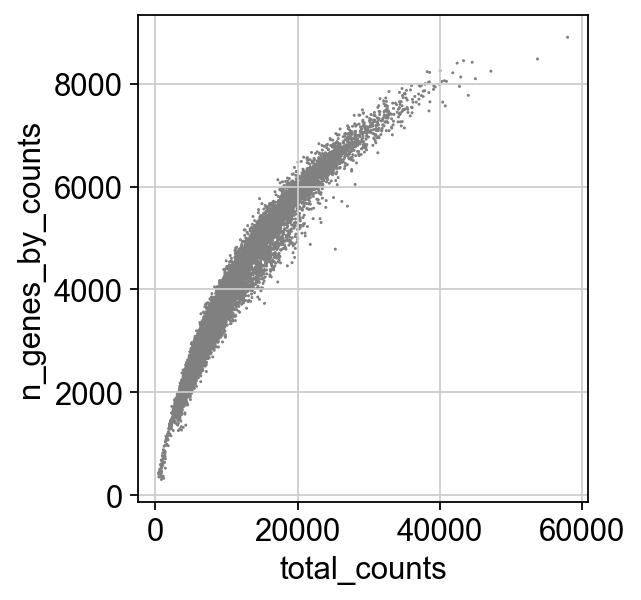

In [8]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [38]:
adata = adata[adata.obs.pct_counts_mt < 6, :]

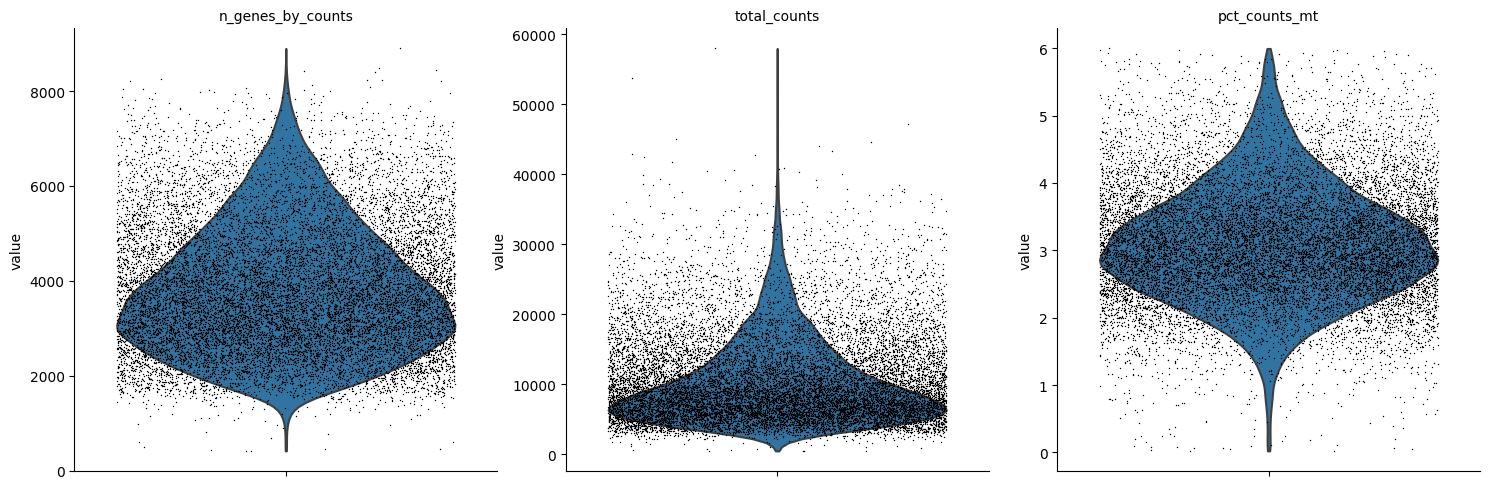

In [15]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

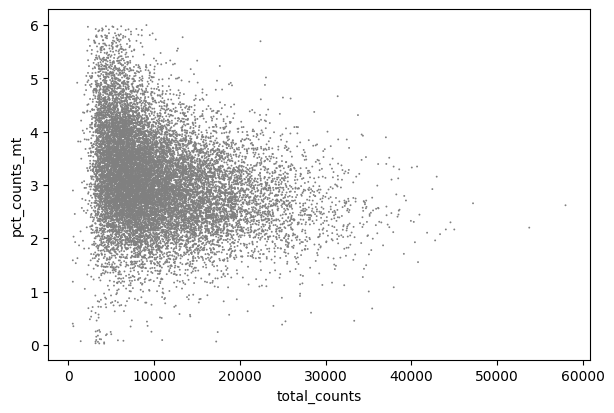

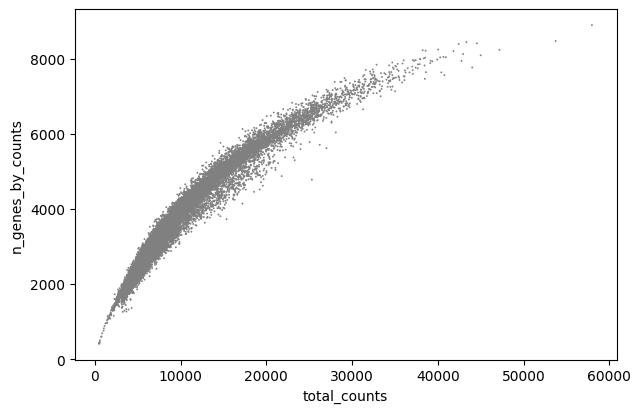

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


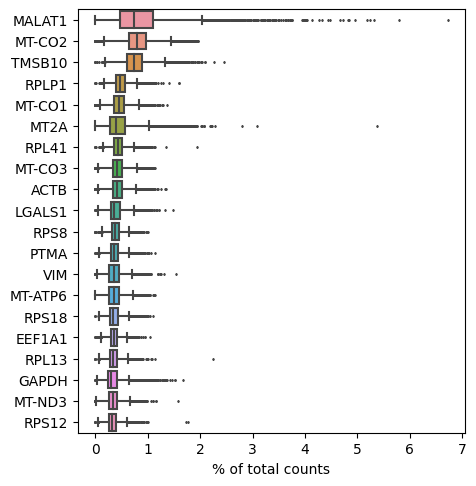

In [17]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [18]:
#makes two lists of mt_genes and non_mt_genes
# its not clear if storing a gene list is better done in an array or list - I use a list here due to familiarity 
mt_genes = []
non_mt_genes = []
for name in adata.var_names:      
    if name[0:3]=='MT-':
        mt_genes.append(name)
        print (name)
    else:
        non_mt_genes.append(name)
print (mt_genes)

MT-ND1
MT-ND2
MT-CO1
MT-CO2
MT-ATP8
MT-ATP6
MT-CO3
MT-ND3
MT-ND4L
MT-ND4
MT-ND5
MT-ND6
MT-CYB
['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


In [ ]:
adata_no_mito_genes = adata[:, non_mt_genes]

In [6]:
sc.pl.highest_expr_genes(adata_no_mito_genes, n_top=20)

NameError: name 'adata_no_mito_genes' is not defined

Normalization
- Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells
- Logarithmize data

In [39]:
sc.pp.normalize_total(adata, target_sum=1e4)

C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [40]:
sc.pp.log1p(adata)

HVG extraction

In [ ]:
#Original criteria for HVG selection
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
#Alternative 
#sc.pp.highly_variable_genes(adata, min_mean=0.005, max_mean=3, min_disp=0.1)

In [41]:
#Top 5000 genes HVG
sc.pp.highly_variable_genes(adata, n_top_genes=5000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


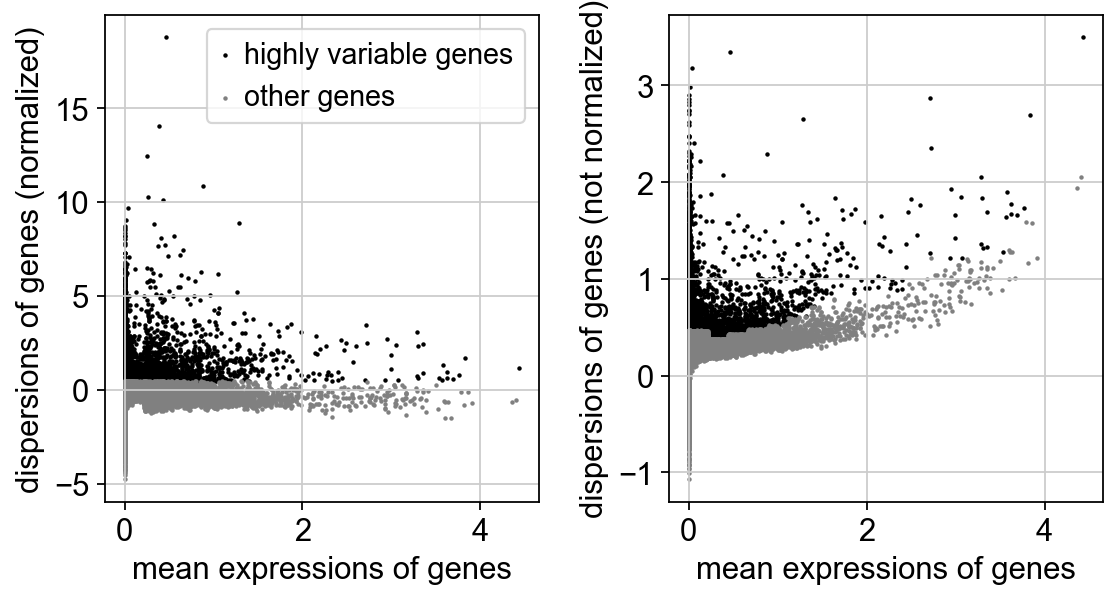

In [42]:
sc.pl.highly_variable_genes(adata)

In [50]:
adata = adata[:, adata.var.highly_variable] #filteringadata.write(results_file)

In [23]:
#skip if regress out and scale below is skipped
adata.raw = adata

View of AnnData object with n_obs × n_vars = 16307 × 5000
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [51]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:03:37)


In [52]:
sc.pp.scale(adata, max_value=10) #Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [55]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)


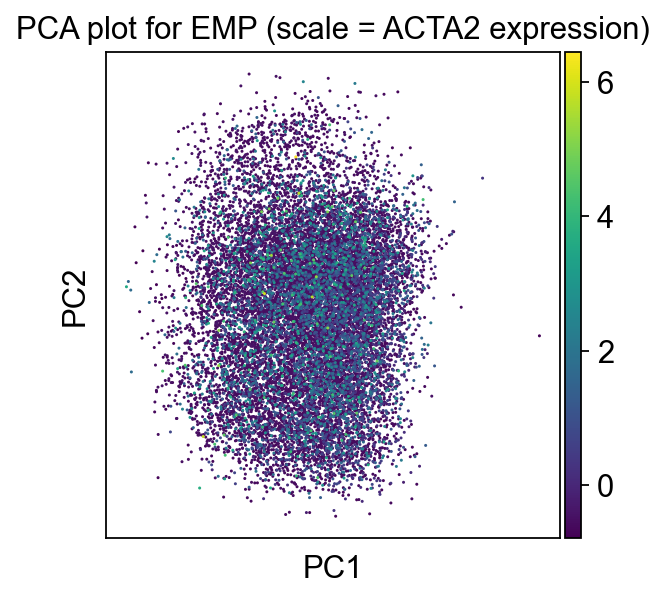

In [53]:
sc.pl.pca(adata, color='ACTA2', title='PCA plot for EMP (scale = ACTA2 expression)')

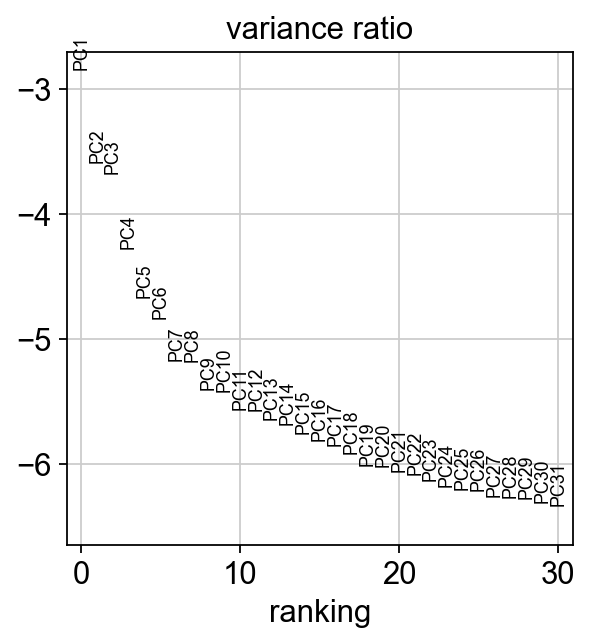

In [54]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
#STOP here
adata.write(results_file)

In [ ]:
adata

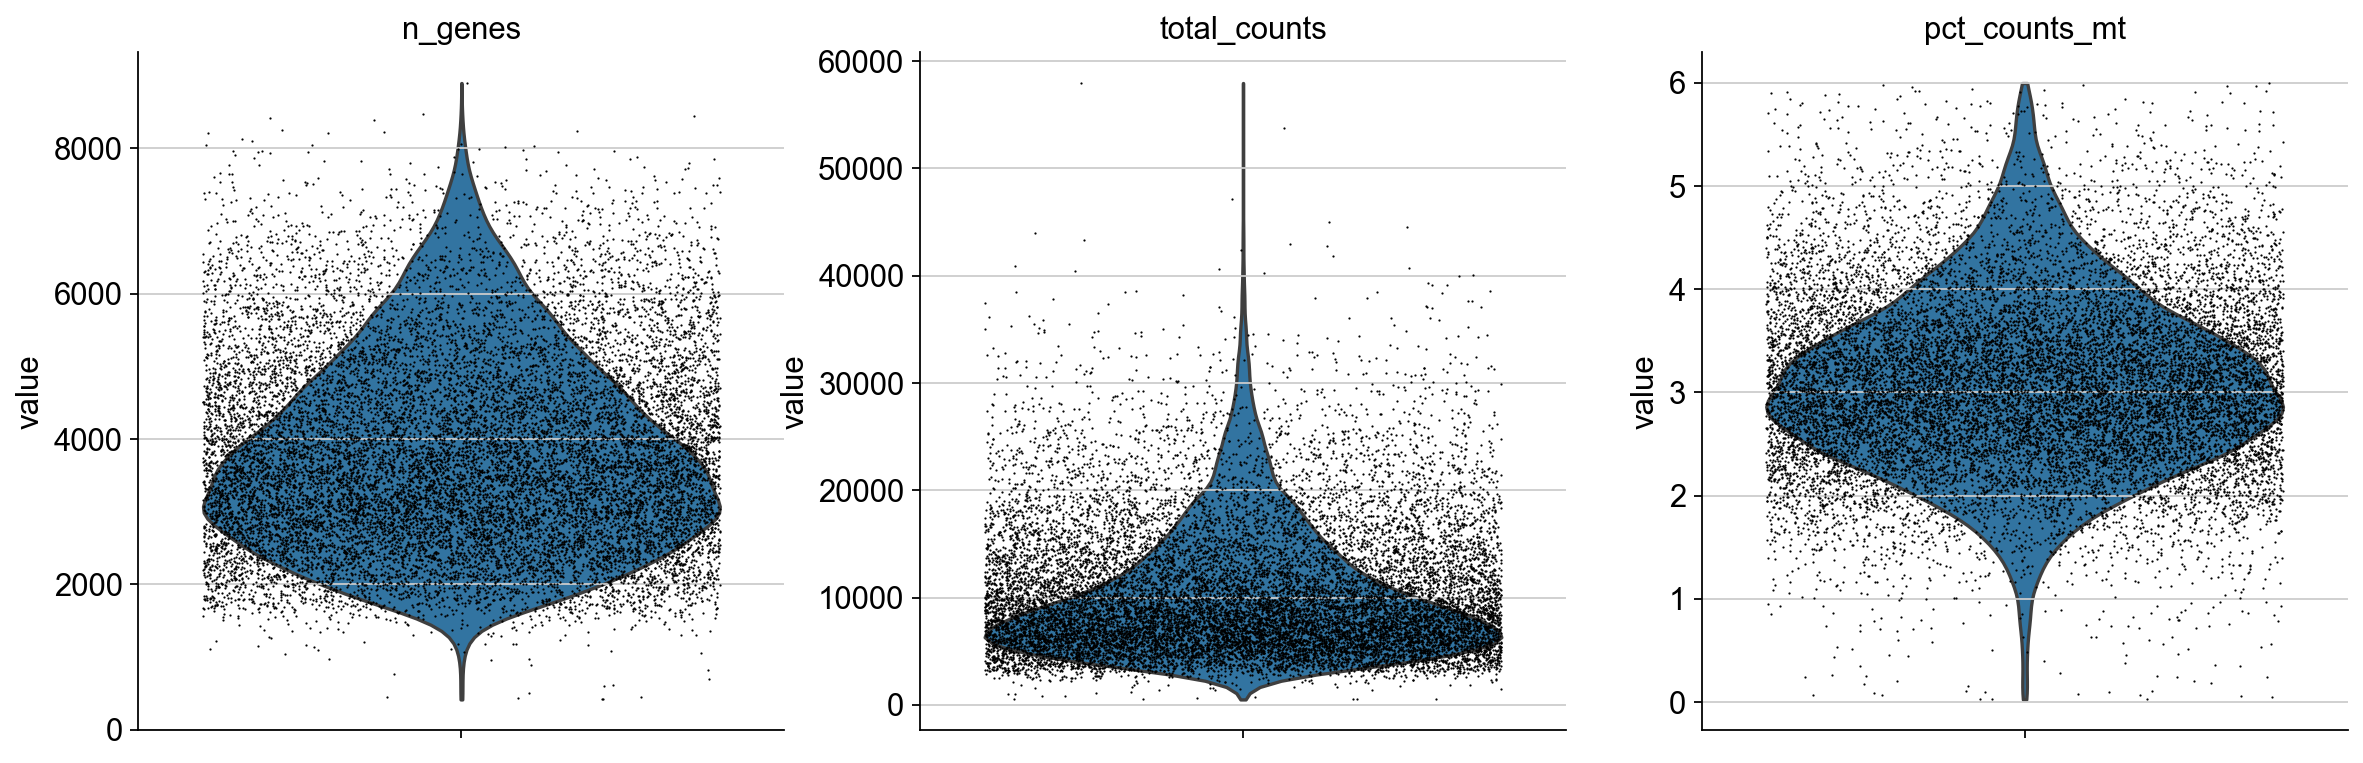

In [46]:
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [40]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [47]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=50)
sc.tl.umap(adata, spread=5.0, min_dist=0.03)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [48]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


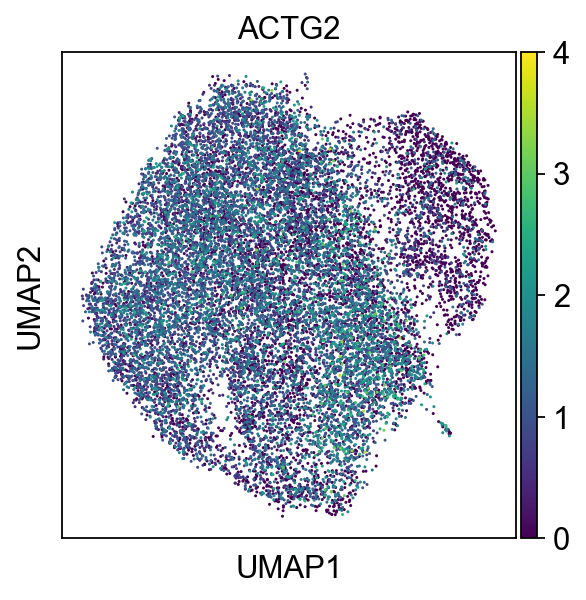

In [49]:
sc.pl.umap(adata, color=['ACTG2'], vmax=4, vmin=0)

In [ ]:
sc.pl.umap(adata, color=['ACTG2'], vmax=4, vmin=0)

In [32]:
sc.tl.leiden(adata)
#see leiden doc here https://arxiv.org/abs/1810.08473

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


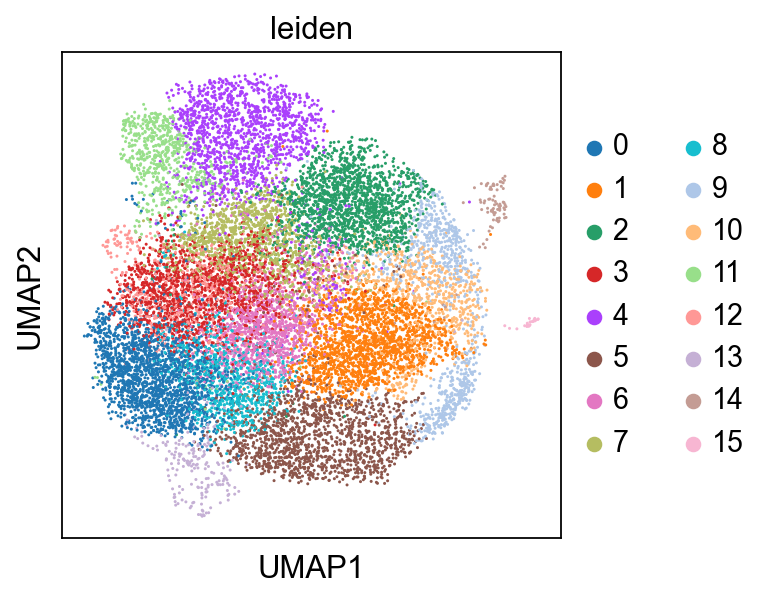

In [33]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
leiden_labels = adata.obs['leiden']
group_idx = leiden_labels[leiden_labels == '4'].index
group_1_adata = adata[group_idx, :]

In [ ]:
group_1_adata

In [ ]:
sc.pl.umap(group_1_adata, color=['leiden'])

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
adata.write(results_file)

In [ ]:
#Long process time - may SKIP
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
marker_genes = ['ACTA2', 'ACTG2', 'ADAMTSL5', 'CNN1', 'GYPC', 'EMILIN1', 'MXRA8', 'SERPINA9']

In [ ]:
marker_genes2 = ['ACTA2', 'ACTG2']
sc.pl.violin(adata, marker_genes2, groupby='leiden')

In [ ]:
sc.pl.violin(adata, marker_genes2)

In [ ]:
#loading write files 
adata = sc.read_h5ad('write/Hir_987.h5ad')

In [ ]:
sc.pl.umap(adata, color=['leiden'])

Integrating datasets 
see
https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html
https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_03_integration.html
Goal is UMAP projection of all samples 
add var of sample label to each 

In [ ]:
sc.settings.verbosity = 2  # a bit more logging

In [2]:
#loading write files 
adata1 = sc.read_h5ad('write/Hir_985.h5ad')
adata2 = sc.read_h5ad('write/Hir_986.h5ad')
adata3 = sc.read_h5ad('write/Hir_987.h5ad')
adata4 = sc.read_h5ad('write/Hir_988.h5ad')
adata5 = sc.read_h5ad('write/Hir_989.h5ad')
adata6 = sc.read_h5ad('write/Hir_990.h5ad')
adata7 = sc.read_h5ad('write/Hir_991.h5ad')
adata8 = sc.read_h5ad('write/Hir_992.h5ad')

In [ ]:
#really good to see what vars have been called upon each cell of the sample
adata.obs
adata1.obs.index

In [3]:
#makes a new obs var called 'sample_id'
adata1.obs['sample_id'] = "EMP"
adata2.obs['sample_id'] = "H2B WT"
adata3.obs['sample_id'] = "H2B E76K"
adata4.obs['sample_id'] = "H2B E76R"
adata5.obs['sample_id'] = "H2B G53D"
adata6.obs['sample_id'] = "H2B G53E"
adata7.obs['sample_id'] = "H2B G53K"
adata8.obs['sample_id'] = "H2B G53R"

In [52]:
#quick way to iterate over all Anndata files
for i in range(1,9):
    print(eval('adata'+str(i)))

AnnData object with n_obs × n_vars = 13771 × 1994
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 16307 × 1871
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'sample_id'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
AnnData object with n_obs × n_vars = 25551 × 1794
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt',

In [53]:
#using for loop to make a new data1 file that combines all annotated anndata 
#data1 = adata1.concatenate(adata2, index_unique=None)
#data1 = data1.concatenate(adata3, index_unique=None)
import time
data1 = adata1
timelist = []
for i in range(2,9):
    t1 = time.perf_counter()
    data1 = data1.concatenate(eval('adata'+str(i)), index_unique=None)
    t2 = time.perf_counter()
    print('Appended adata'+str(i)+' in '+str(round(t2-t1,3))+' seconds')
    timelist.append(str(round(t2-t1,3)))

C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Appended adata2 in 1.511 seconds


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.

Appended adata3 in 3.626 seconds


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.

Appended adata4 in 8.328 seconds


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.

Appended adata5 in 25.061 seconds


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.

Appended adata6 in 36.66 seconds


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.

Appended adata7 in 37.276 seconds


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.

Appended adata8 in 35.539 seconds


In [ ]:
#print(timelist)

In [48]:
#data1.write('write/merge_8samples.h5ad')

NameError: name 'data1' is not defined

In [3]:
data1 = sc.read_h5ad('write/merge_8samples.h5ad')

C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
marker_genes2 = ['ACTA2', 'ACTG2', 'ACTB']
#sc.pl.violin(data1, marker_genes2, groupby='sample_id', jitter=0.4, size=0.35)
sc.pl.violin(data1,'ACTN1', groupby='sample_id', jitter=0.4, size=0.35)

In [ ]:
# Perform UMAP projection
sc.pp.neighbors(data1)
sc.tl.umap(data1)

# Plot the UMAP projection with sample labels
sc.pl.umap(data1, color='sample_id')

DE analysis between each sample from combined file

In [ ]:
sc.tl.rank_genes_groups(data1, 'sample_id', method='wilcoxon')
sc.pl.rank_genes_groups(data1, n_genes=25, sharey=False)
pd.DataFrame(data1.uns['rank_genes_groups']['names']).head(10)

In [ ]:
#new data that excludes G53 mutants
import time
data2 = adata1
for i in range(2,5):
    t1 = time.perf_counter()
    data2 = data2.concatenate(eval('adata'+str(i)), index_unique=None)
    t2 = time.perf_counter()
    print('Appended adata'+str(i)+' in '+str(round(t2-t1,3))+' seconds')

In [ ]:
# Perform UMAP projection
sc.pp.neighbors(data2)
sc.tl.umap(data2)

# Plot the UMAP projection with sample labels
sc.pl.umap(data2, color='sample_id')

In [23]:
#E76K vs. WT
import time
data3 = adata2
for i in range(3,4):
    t1 = time.perf_counter()
    data3 = data3.concatenate(eval('adata'+str(i)), index_unique=None)
    t2 = time.perf_counter()
    print('Appended adata'+str(i)+' in '+str(round(t2-t1,3))+' seconds')

Appended adata3 in 5.284 seconds


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [116]:
sc.tl.rank_genes_groups(data3, 'sample_id', method='wilcoxon')
sc.pl.rank_genes_groups(data3, n_genes=25, sharey=False)

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(data3.uns['rank_genes_groups']['names']).head(50)

In [105]:
de_genes = data3.uns['rank_genes_groups']['names']['H2B E76K'][0:100]
#convert the numpy ndarray to a list of gene names before passing it to the 'sc.queries.enrich' function
de_genes = de_genes.tolist()
GO_d3 = sc.queries.enrich(de_genes, org='hsapiens', gprofiler_kwargs={'sources' : ['GO:BP'], 'no_evidences':False})

In [106]:
GO_d3

source      native                                             name  \
0   GO:BP  GO:0002181                          cytoplasmic translation   
1   GO:BP  GO:0006412                                      translation   
2   GO:BP  GO:0043043                     peptide biosynthetic process   
3   GO:BP  GO:0043604                       amide biosynthetic process   
4   GO:BP  GO:0006518                        peptide metabolic process   
5   GO:BP  GO:0034645      cellular macromolecule biosynthetic process   
6   GO:BP  GO:0009059               macromolecule biosynthetic process   
7   GO:BP  GO:1901566     organonitrogen compound biosynthetic process   
8   GO:BP  GO:0044271  cellular nitrogen compound biosynthetic process   
9   GO:BP  GO:0043603                 cellular amide metabolic process   
10  GO:BP  GO:0009058                             biosynthetic process   
11  GO:BP  GO:1901576           organic substance biosynthetic process   
12  GO:BP  GO:0044249                    cellular biosynthetic process   
13  GO:BP  GO:0030029                     actin filament-based process   
14  GO:BP  GO:0042060                                    wound healing   
15  GO:BP  GO:0044260         cellular macromolecule metabolic process   
16  GO:BP  GO:0097435                supramolecular fiber organization   
17  GO:BP  GO:0030036                  actin cytoskeleton organization   
18  GO:BP  GO:0009611                             response to wounding   
19  GO:BP  GO:0048870                                    cell motility   
20  GO:BP  GO:0048856                 anatomical structure development   
21  GO:BP  GO:0032502                            developmental process   
22  GO:BP  GO:0001568                         blood vessel development   
23  GO:BP  GO:0016477                                   cell migration   
24  GO:BP  GO:0001944                          vasculature development   
25  GO:BP  GO:0019538                        protein metabolic process   
26  GO:BP  GO:0061061                     muscle structure development   
27  GO:BP  GO:0009888                               tissue development   
28  GO:BP  GO:0030334                     regulation of cell migration   
29  GO:BP  GO:0048869                   cellular developmental process   
30  GO:BP  GO:0007015                      actin filament organization   
31  GO:BP  GO:0009653               anatomical structure morphogenesis   
32  GO:BP  GO:2000145                      regulation of cell motility   
33  GO:BP  GO:0071495         cellular response to endogenous stimulus   
34  GO:BP  GO:0040011                                       locomotion   
35  GO:BP  GO:0072359                   circulatory system development   
36  GO:BP  GO:0031069                      hair follicle morphogenesis   
37  GO:BP  GO:0030154                             cell differentiation   
38  GO:BP  GO:0040012                         regulation of locomotion   
39  GO:BP  GO:1901564        organonitrogen compound metabolic process   
40  GO:BP  GO:0048730                          epidermis morphogenesis   

         p_value  significant  \
0   1.373570e-18         True   
1   5.482648e-11         True   
2   1.273198e-10         True   
3   3.801583e-09         True   
4   7.632413e-09         True   
5   3.887996e-08         True   
6   3.692863e-07         True   
7   4.106261e-07         True   
8   5.563360e-07         True   
9   1.615337e-06         True   
10  2.388548e-06         True   
11  4.641251e-06         True   
12  9.831150e-06         True   
13  6.437762e-05         True   
14  2.759658e-04         True   
15  2.971191e-04         True   
16  3.481784e-04         True   
17  4.461326e-04         True   
18  8.367901e-04         True   
19  1.219212e-03         True   
20  1.284605e-03         True   
21  1.442163e-03         True   
22  1.750366e-03         True   
23  2.154201e-03         True   
24  2.998154e-03         True   
25  3.499427e-03         True   
26 

In [118]:
GO_d3.head(20)
GO_d3.to_csv("GO_d3.csv")

In [ ]:
# Perform UMAP projection
sc.pp.neighbors(data3)
sc.tl.umap(data3)

# Plot the UMAP projection with sample labels
sc.pl.umap(data3, color='sample_id')

In [ ]:
sc.pl.umap(data3, color=['ACTA2'])

In [ ]:
sc.pl.umap(data3, color=['ACTG2'])

In [ ]:
sc.tl.leiden(data3)
sc.pl.umap(data3, color=['leiden'])

In [ ]:
marker_genes2 = ['ACTA2', 'ACTG2']
sc.pl.violin(data3, marker_genes2, groupby='leiden')

In [ ]:
#Goal is to output ratio of WT / mut cells in each group
#makes a dict of each subset of data4 based on leiden value
leiden_list = {}
for i in range(0,12):
    leiden_list[i]=data4[data4.obs['leiden']== str(i),]
    print(leiden_list[i])

In [ ]:
ratio = []
for i in range(0,12):
    swt = sum(leiden_list[i].obs.sample_id=='H2B WT')
    smut = sum(leiden_list[i].obs.sample_id=='H2B E76R')
    ratio.append(swt/(swt+smut))
    print(swt/(swt+smut))

In [ ]:
x = range(len(ratio))
plt.bar(x, ratio)
#plt.ylabel('Value')
plt.title('H2BWT vs H2B E76K')
plt.suptitle('Proportion of cells that are H2B WT in each leiden group', fontsize=15, y=1.05)
plt.show()

In [70]:
#E76R vs. WT
import time
data4 = adata2
for i in range(4,5):
    t1 = time.perf_counter()
    data4 = data4.concatenate(eval('adata'+str(i)), index_unique=None)
    t2 = time.perf_counter()
    print('Appended adata'+str(i)+' in '+str(round(t2-t1,3))+' seconds')

Appended adata4 in 2.548 seconds


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


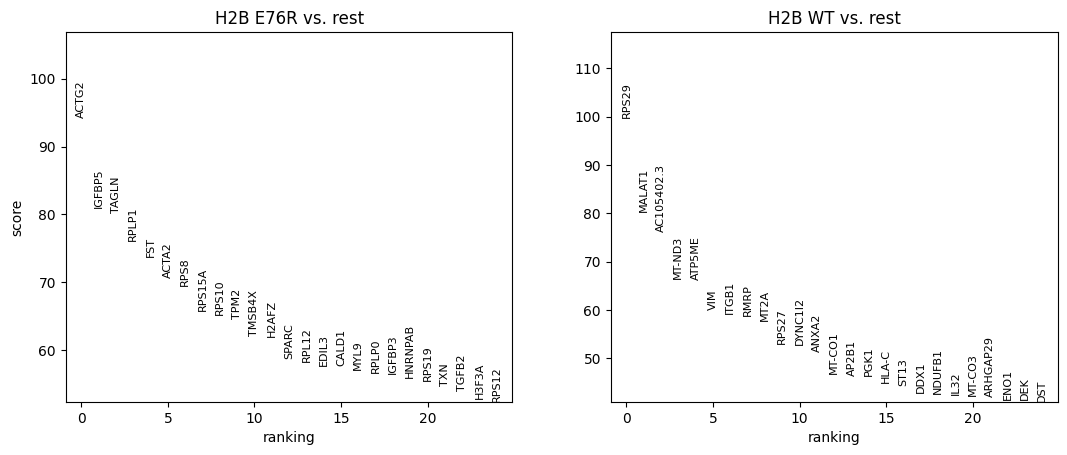

H2B E76R      H2B WT
0      ACTG2       RPS29
1     IGFBP5      MALAT1
2      TAGLN  AC105402.3
3      RPLP1      MT-ND3
4        FST      ATP5ME
5      ACTA2         VIM
6       RPS8       ITGB1
7     RPS15A        RMRP
8      RPS10        MT2A
9       TPM2       RPS27
10    TMSB4X     DYNC1I2
11     H2AFZ       ANXA2
12     SPARC      MT-CO1
13     RPL12       AP2B1
14     EDIL3        PGK1
15     CALD1       HLA-C
16      MYL9        ST13
17     RPLP0        DDX1
18    IGFBP3      NDUFB1
19   HNRNPAB        IL32
20     RPS19      MT-CO3
21       TXN    ARHGAP29
22     TGFB2        ENO1
23     H3F3A         DEK
24     RPS12         DST
25     RPL23    SERPINE1
26    TMSB10       MYEF2
27  SERPINH1      ZNHIT1
28      TPM1       TUBB3
29     NRXN3       EIF5B

In [71]:
sc.tl.rank_genes_groups(data4, 'sample_id', method='wilcoxon')
sc.pl.rank_genes_groups(data4, n_genes=25, sharey=False)
pd.DataFrame(data4.uns['rank_genes_groups']['names']).head(30)

In [109]:
de_genes = data4.uns['rank_genes_groups']['names']['H2B E76R'][0:50]
#convert the numpy ndarray to a list of gene names before passing it to the 'sc.queries.enrich' function
de_genes = de_genes.tolist()
GO_d4 = sc.queries.enrich(de_genes, org='hsapiens', gprofiler_kwargs={'sources' : ['GO:BP'], 'no_evidences':False})

In [113]:
GO_d4.head(20)
GO_d4.to_csv("GO_d4.csv")

In [ ]:
# Perform UMAP projection
sc.pp.neighbors(data4)
sc.tl.umap(data4)

# Plot the UMAP projection with sample labels
sc.pl.umap(data4, color='sample_id')

In [ ]:
#making alternative UMAPs
# Perform UMAP projection
sc.pp.neighbors(data4, n_neighbors=100)
sc.tl.umap(data4, n_components=3, min_dist=0.5, spread=2.0)

# Plot the UMAP projection with sample labels
sc.pl.umap(data4, color='sample_id')

In [ ]:
sc.pl.umap(data4, color=['ACTA2'])

In [ ]:
sc.pl.umap(data4,color=['ACTG2'])

In [ ]:
sc.tl.leiden(data4)
sc.pl.umap(data4, color=['leiden'])

In [ ]:
marker_genes2 = ['ACTA2', 'ACTG2']
marker_genes4 = ['COL11A1', 'COL12A1', 'COL1A1', 'COL1A2', 'COL25A1']
marker_genes5 = ['COL3A1', 'COL4A1', 'COL5A2', 'COL5A3', 'COL6A1']

sc.pl.violin(data3, marker_genes4, groupby='leiden')

In [ ]:
#Goal is to output ratio of WT / mut cells in each group
#makes a dict of each subset of data4 based on leiden value
leiden_list = {}
for i in range(0,14):
    leiden_list[i]=data4[data4.obs['leiden']== str(i),]
    print(leiden_list[i])

In [ ]:
ratio = []
for i in range(0,14):
    swt = sum(leiden_list[i].obs.sample_id=='H2B WT')
    smut = sum(leiden_list[i].obs.sample_id=='H2B E76R')
    ratio.append(swt/(swt+smut))
    print(swt/(swt+smut))

In [ ]:
import matplotlib.pyplot as plt
x = range(len(ratio))
plt.bar(x, ratio)
#plt.ylabel('Value')
plt.title('H2BWT vs H2B E76R')
plt.suptitle('Proportion of cells that are H2B WT in each leiden group', fontsize=15, y=1.05)
plt.show()

In [ ]:
#SKIP
leiden_labels = data4.obs['leiden']
group_idx = leiden_labels[leiden_labels == '4']
group_1_adata = data4[group_idx, :]
# dosnt work because two datasets were merged - resulting in overlapping cell IDs / barcodes

In [ ]:
#output ratio of WT / mut cells in each group
#output ratio of expression of target gene between WT / mut in each group
#do cells that have high ACTA2 also have high ACTG2?

In [ ]:
genes = ['ACTA2', 'ACTG2']
sc.pl.violin(adata2, genes, show=False)
plt.gca().set_title("ACTA2 and ACTG2 expression in H2B WT cells")
plt.show()

In [ ]:
sc.pl.scatter(adata2, x='ACTA2', y='ACTG2', show=False)
plt.gca().set_title("ACTA2 vs ACTG2 expression in H2B WT cells")
plt.show()

In [ ]:
genes = ['ACTA2', 'ACTG2']
sc.pl.violin(adata3, genes, show=False)
plt.gca().set_title("ACTA2 and ACTG2 expression in H2B E76K cells")
plt.show()

In [ ]:
sc.pl.scatter(adata3, x='ACTA2', y='ACTG2', show=False)
plt.gca().set_title("ACTA2 vs ACTG2 expression in H2B E76K cells")
plt.show()

In [ ]:
genes = ['ACTA2', 'ACTG2']
sc.pl.violin(adata4, genes, show=False)
plt.gca().set_title("ACTA2 and ACTG2 expression in H2B E76R cells")
plt.show()

In [ ]:
sc.pl.scatter(adata4, x='ACTA2', y='ACTG2', show=False)
plt.gca().set_title("ACTA2 vs ACTG2 expression in H2B E76R cells")
plt.show()

In [ ]:
df = adata2.to_df()

In [ ]:
import seaborn as sns
tips = sns.load_dataset('tips')
sns.regplot(x=df['ACTA2'], y=df['ACTG2'], marker='o', color='green', scatter_kws={'s':2})
plt.title('Coexpression Plot of ACTA2 and ACTG2 for H2B WT')

In [ ]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(df['ACTA2'], df['ACTG2'])

In [ ]:
corr

In [ ]:
adata4[adata4.var=='ACTA2',]

In [ ]:
s=data4.var.index[data4.var.index=='FMN2']

In [ ]:
s

In [ ]:
data4.var.index=='FMN2'

In [ ]:
#custom aligner for FLAG transcripts?
#add to ref transcriptome FLAG-transcript and realign?
#24 FLAG region can be mapped - its on 3' end

In [4]:
#G53D vs. WT
import time
data5 = adata2
for i in range(5,6):
    t1 = time.perf_counter()
    data5 = data5.concatenate(eval('adata'+str(i)), index_unique=None)
    t2 = time.perf_counter()
    print('Appended adata'+str(i)+' in '+str(round(t2-t1,3))+' seconds')

Appended adata5 in 1.935 seconds


C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


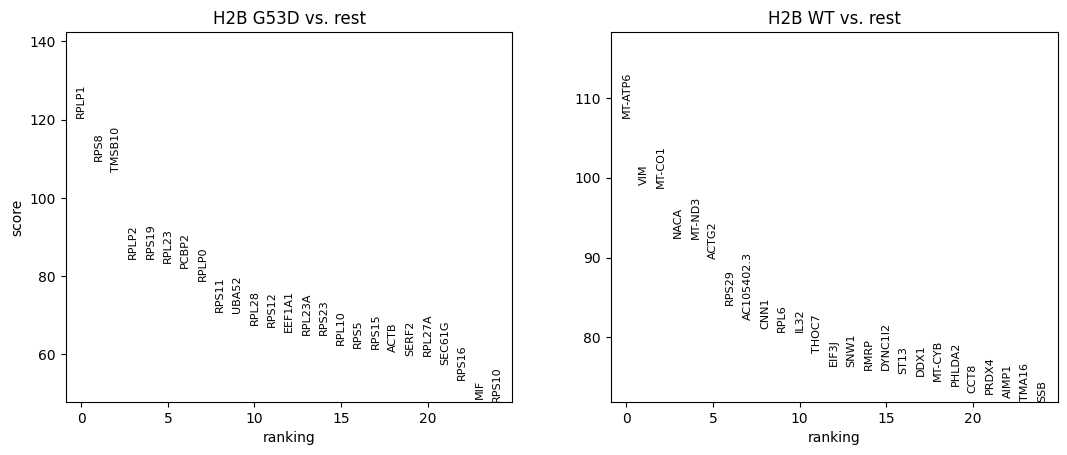

H2B G53D      H2B WT
0     RPLP1     MT-ATP6
1      RPS8         VIM
2    TMSB10      MT-CO1
3     RPLP2        NACA
4     RPS19      MT-ND3
5     RPL23       ACTG2
6     PCBP2       RPS29
7     RPLP0  AC105402.3
8     RPS11        CNN1
9     UBA52        RPL6
10    RPL28        IL32
11    RPS12       THOC7
12   EEF1A1       EIF3J
13   RPL23A        SNW1
14    RPS23        RMRP
15    RPL10     DYNC1I2
16     RPS5        ST13
17    RPS15        DDX1
18     ACTB      MT-CYB
19    SERF2      PHLDA2
20   RPL27A        CCT8
21   SEC61G       PRDX4
22    RPS16       AIMP1
23      MIF       TMA16
24    RPS10         SSB
25   RPL18A         MDK
26      FAU     MT-ND4L
27     RPL4       PSMC5
28   NUCKS1       TAGLN
29    RPS21       RPL21

In [5]:
sc.tl.rank_genes_groups(data5, 'sample_id', method='wilcoxon')
sc.pl.rank_genes_groups(data5, n_genes=25, sharey=False)
pd.DataFrame(data5.uns['rank_genes_groups']['names']).head(30)

In [7]:
de_genes = data5.uns['rank_genes_groups']['names']['H2B G53D'][0:100]
#convert the numpy ndarray to a list of gene names before passing it to the 'sc.queries.enrich' function
de_genes = de_genes.tolist()
GO_d5 = sc.queries.enrich(de_genes, org='hsapiens', gprofiler_kwargs={'sources' : ['GO:BP'], 'no_evidences':False})

In [8]:
GO_d5

source      native                                               name  \
0   GO:BP  GO:0002181                            cytoplasmic translation   
1   GO:BP  GO:0006412                                        translation   
2   GO:BP  GO:0043043                       peptide biosynthetic process   
3   GO:BP  GO:0043604                         amide biosynthetic process   
4   GO:BP  GO:0006518                          peptide metabolic process   
5   GO:BP  GO:0034645        cellular macromolecule biosynthetic process   
6   GO:BP  GO:0043603                   cellular amide metabolic process   
7   GO:BP  GO:1901566       organonitrogen compound biosynthetic process   
8   GO:BP  GO:0044260           cellular macromolecule metabolic process   
9   GO:BP  GO:0009059                 macromolecule biosynthetic process   
10  GO:BP  GO:0019538                          protein metabolic process   
11  GO:BP  GO:0044271    cellular nitrogen compound biosynthetic process   
12  GO:BP  GO:0044249                      cellular biosynthetic process   
13  GO:BP  GO:1901576             organic substance biosynthetic process   
14  GO:BP  GO:0009058                               biosynthetic process   
15  GO:BP  GO:1901564          organonitrogen compound metabolic process   
16  GO:BP  GO:0042274                 ribosomal small subunit biogenesis   
17  GO:BP  GO:0042255                                  ribosome assembly   
18  GO:BP  GO:0042254                                ribosome biogenesis   
19  GO:BP  GO:0010467                                    gene expression   
20  GO:BP  GO:0044237                         cellular metabolic process   
21  GO:BP  GO:0034641       cellular nitrogen compound metabolic process   
22  GO:BP  GO:0000028                   ribosomal small subunit assembly   
23  GO:BP  GO:0140694            non-membrane-bounded organelle assembly   
24  GO:BP  GO:1904667  negative regulation of ubiquitin protein ligas...   
25  GO:BP  GO:0006807                nitrogen compound metabolic process   
26  GO:BP  GO:0043170                    macromolecule metabolic process   
27  GO:BP  GO:0000462  maturation of SSU-rRNA from tricistronic rRNA ...   
28  GO:BP  GO:0008152                                  metabolic process   
29  GO:BP  GO:0006364                                    rRNA processing   
30  GO:BP  GO:0044238                          primary metabolic process   
31  GO:BP  GO:0051444  negative regulation of ubiquitin-protein trans...   
32  GO:BP  GO:0016072                             rRNA metabolic process   
33  GO:BP  GO:0030490                             maturation of SSU-rRNA   
34  GO:BP  GO:1904666    regulation of ubiquitin protein ligase activity   
35  GO:BP  GO:0000027                   ribosomal large subunit assembly   
36  GO:BP  GO:1901798  positive regulation of signal transduction by ...   

         p_value  significant  \
0   1.319313e-70         True   
1   8.387943e-44         True   
2   5.802163e-43         True   
3   1.497160e-39         True   
4   7.608173e-39         True   
5   9.313809e-35         True   
6   2.483349e-33         True   
7   1.856098e-27         True   
8   2.018336e-22         True   
9   1.735478e-17         True   
10  8.254945e-17         True   
11  2.208217e-16         True   
12  1.456645e-14         True   
13  2.934225e-14         True   
14  6.740817e-14         True   
15  6.753199e-14         True   
16  4.793158e-09         True   
17  1.941050e-08         True   
18  2.782601e-07         True   
19  2.909827e-07         True   
20  2.336309e-06         True   
21  2.871174e-06         True   
22  2.480519e-05         True   
23  4.993327e-05         True   
24  6.647451e-04         True   
25  7.085146e-04         True   
26  1.237108e-03         True   
27  1.865669e-03         True   
28  2.009450e-03         True   
29  2.527462e-03         True   
30  6.882651e-03         True   
31  7.950158e-03         True   
32  8.887425e-03         

In [ ]:
# Perform UMAP projection
sc.pp.neighbors(data5)
sc.tl.umap(data5)

# Plot the UMAP projection with sample labels
sc.pl.umap(data5, color='sample_id')
sc.pl.umap(data5, color=['ACTA2'])
sc.pl.umap(data5,color=['ACTG2'])

In [ ]:
#G53E vs. WT
import time
data5 = adata2
for i in range(6,7):
    t1 = time.perf_counter()
    data5 = data5.concatenate(eval('adata'+str(i)), index_unique=None)
    t2 = time.perf_counter()
    print('Appended adata'+str(i)+' in '+str(round(t2-t1,3))+' seconds')


In [ ]:
sc.tl.rank_genes_groups(data5, 'sample_id', method='wilcoxon')
sc.pl.rank_genes_groups(data5, n_genes=25, sharey=False)
pd.DataFrame(data5.uns['rank_genes_groups']['names']).head(30)

In [ ]:
# Perform UMAP projection
sc.pp.neighbors(data5)
sc.tl.umap(data5)

# Plot the UMAP projection with sample labels
sc.pl.umap(data5, color='sample_id')
sc.pl.umap(data5, color=['ACTA2'])
sc.pl.umap(data5,color=['ACTG2'])

In [ ]:
#G53K vs. WT
import time
data5 = adata2
for i in range(7,8):
    t1 = time.perf_counter()
    data5 = data5.concatenate(eval('adata'+str(i)), index_unique=None)
    t2 = time.perf_counter()
    print('Appended adata'+str(i)+' in '+str(round(t2-t1,3))+' seconds')


In [ ]:
sc.tl.rank_genes_groups(data5, 'sample_id', method='wilcoxon')
sc.pl.rank_genes_groups(data5, n_genes=25, sharey=False)
pd.DataFrame(data5.uns['rank_genes_groups']['names']).head(30)

In [ ]:
# Perform UMAP projection
sc.pp.neighbors(data5)
sc.tl.umap(data5)

# Plot the UMAP projection with sample labels
sc.pl.umap(data5, color='sample_id')
sc.pl.umap(data5, color=['ACTA2'])
sc.pl.umap(data5,color=['ACTG2'])

In [ ]:
#G53R vs. WT
import time
data5 = adata2
for i in range(8,9):
    t1 = time.perf_counter()
    data5 = data5.concatenate(eval('adata'+str(i)), index_unique=None)
    t2 = time.perf_counter()
    print('Appended adata'+str(i)+' in '+str(round(t2-t1,3))+' seconds')


In [ ]:
sc.tl.rank_genes_groups(data5, 'sample_id', method='wilcoxon')
sc.pl.rank_genes_groups(data5, n_genes=25, sharey=False)
pd.DataFrame(data5.uns['rank_genes_groups']['names']).head(30)

In [ ]:
# Perform UMAP projection
sc.pp.neighbors(data5)
sc.tl.umap(data5)

# Plot the UMAP projection with sample labels
sc.pl.umap(data5, color='sample_id')
sc.pl.umap(data5, color=['ACTA2'])
sc.pl.umap(data5,color=['ACTG2'])

In [46]:
adata2 = adata4

In [47]:
sc.pp.neighbors(adata2, n_neighbors=5, n_pcs=50)
sc.tl.umap(adata2, spread=5.0, min_dist=0.03)

C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [48]:
sc.tl.leiden(adata2)

(0.0, 3.5)

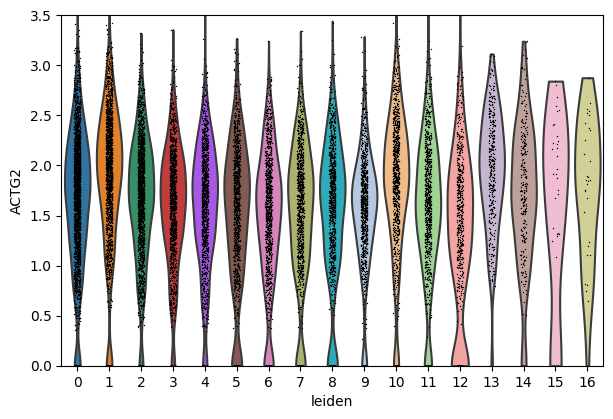

In [52]:
ax = sc.pl.violin(adata2, ['ACTG2'], groupby='leiden', show=False)
ax.set_ylim(bottom=0,top=3.5)

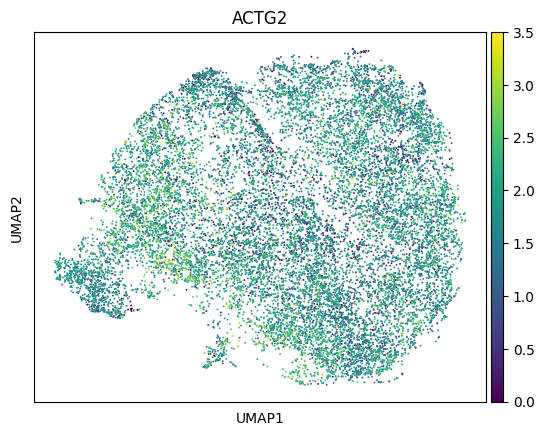

In [53]:
sc.pl.umap(adata2, color=['ACTG2'], vmax=3.5, vmin=0)

C:\Users\zchua\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


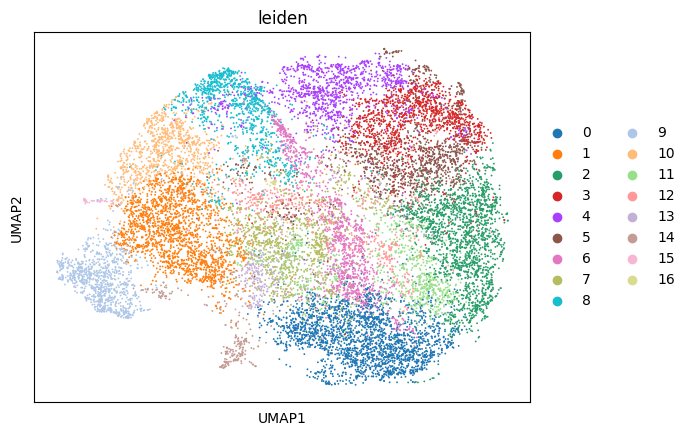

In [51]:
sc.pl.umap(adata2, color=['leiden'])